In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, rc, rcParams
import seaborn as sns
from scipy.stats import gaussian_kde
import pandas as pd
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import corner

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from tqdm import tqdm

In [3]:
import corner_plot_settings as pltu_corn
import plot_utils as pltu
from UNITS import *

In [4]:
import scipy.integrate as integrate
from scipy.interpolate import interp1d

In [5]:
import json

In [6]:
pltu.plot_settings(rc, rcParams)

In [7]:
GW241011_data_file = 'GW241011_GW241110_data_release/data/ancestors/GW241011_ancestral_properties_forwards.json'
GW241110_data_file = 'GW241011_GW241110_data_release/data/ancestors/GW241110_ancestral_properties_forwards.json'

In [8]:
f = open(GW241011_data_file)
data_GW241011 = json.load(f)
f.close()

In [9]:
f = open(GW241110_data_file)
data_GW241110 = json.load(f)
f.close()

In [11]:
data_GW241011['posterior']['content'].keys()

dict_keys(['mass_1_source', 'mass_ratio', 'a_1', 'a_2', 'cos_tilt_1', 'cos_tilt_2', 'phi_12', 'log_likelihood', 'log_prior', 'chi_eff', 'chi_p', 'final_mass_source', 'final_spin', 'final_kick'])

In [12]:
vr_post_GW241011 = np.array(data_GW241011['posterior']['content']['final_kick'])
vr_post_GW241110 = np.array(data_GW241110['posterior']['content']['final_kick'])

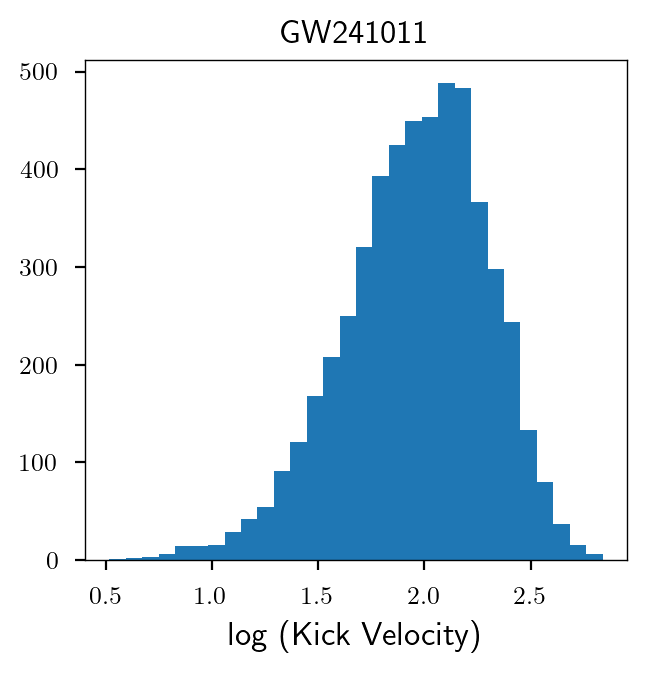

In [16]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(np.log10(vr_post_GW241011), bins = 30)
plt.title(r'GW241011')
plt.xlabel(r'log (Kick Velocity)')
plt.show()

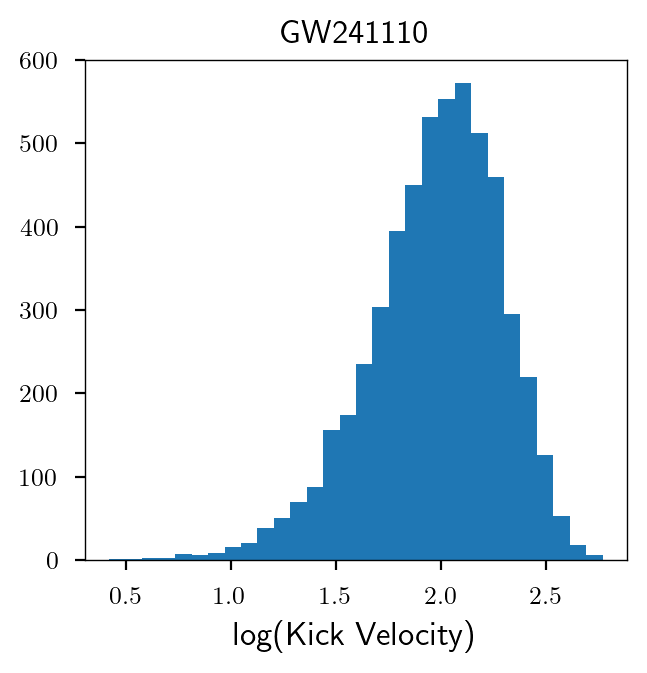

In [19]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(np.log10(vr_post_GW241110), bins = 30)
plt.xlabel(r'log(Kick Velocity)')
plt.title(r'GW241110')
plt.show()

In [21]:
def get_v_esc(M0, a, r):
    psi = G * 10**M0 * M_sun / (a * PC) / np.sqrt(1 + (r / a)**2)
    return np.sqrt(2 * psi) / 1e3               # in km/s

In [26]:
def p_of_v(v, v_esc):
    x = v / v_esc
    p_v = 512 / 7 / np.pi / v_esc * x**2 * (1 - x**2)**7/2
    return p_v

In [27]:
def p_of_r(r, a):
    x = r / a
    return 3 * x**2 * (1 + x**2)**(-5/2) / a

In [28]:
def generate_samps_from_post(N, post):
    hist, bin_edges = np.histogram(post, bins=1000, density=True)
    cdf = np.cumsum(hist * np.diff(bin_edges))
    cdf /= cdf[-1]
    u = np.random.rand(N)
    samples = np.interp(u, cdf, bin_edges[1:])
    return samples

In [29]:
def generate_samps_from_dist(N, init_samp, pdf):
    init_samp_pdf = pdf(init_samp)
    cdf = integrate.cumulative_trapezoid(init_samp_pdf, init_samp, initial=0)
    cdf /= cdf[-1]
    u = np.random.rand(N)
    samples = np.interp(u, cdf, init_samp)
    return samples

In [37]:
def sample_inv_square(xmin, xmax, size=1):
    u = np.random.uniform(0, 1, size)
    A = 1.0 / xmin
    B = 1.0 / xmax
    return 1.0 / (A - u * (A - B))

In [209]:
np.random.seed(1234)

In [211]:
N = 300000
M0_samp = np.log10(sample_inv_square(1e4, 1e10, size=N))          # M0 uniform in Log Space
a_samp = np.random.uniform(1, 4, N)
cos_theta_samp = np.random.uniform(-1, 1, N)

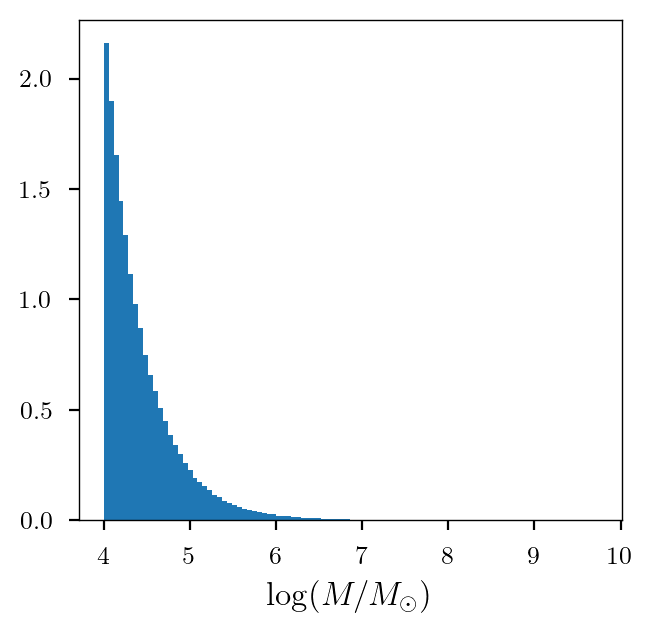

In [212]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(M0_samp, bins = 100, density = True)
#plt.hist(10**(M0_samp[idx]), bins = 1000, density = True)
#plt.xscale('log')
plt.xlabel(r'$\log(M / M_{\odot})$')
plt.show()

In [213]:
vr_samp_GW241011 = generate_samps_from_post(N, vr_post_GW241011)
vr_samp_GW241110 =  generate_samps_from_post(N, vr_post_GW241110)

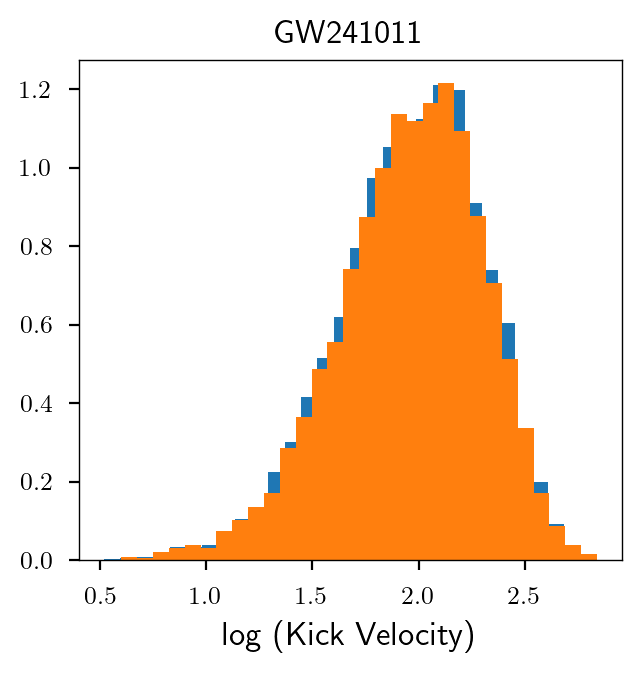

In [215]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(np.log10(vr_post_GW241011), density = True, bins = 30)
plt.hist(np.log10(generate_samps_from_post(N, vr_post_GW241011)), density = True, bins = 30)
plt.title(r'GW241011')
plt.xlabel(r'log (Kick Velocity)')
plt.show()

In [217]:
r_init = np.linspace(0, 20, 1000)

In [219]:
#r_dist_func = lambda x: p_of_r(x, a_samp[0])
#generate_samps_from_dist(1, r_init, r_dist_func)

In [221]:
pofr_samps = p_of_r(r_init, a_samp[:, np.newaxis])

In [224]:
cdf_samps = integrate.cumulative_trapezoid(pofr_samps, r_init, initial=0, axis = -1)

In [225]:
cdf_samps = cdf_samps / cdf_samps[:, -1][:, None]

In [226]:
u = np.random.rand(N)

In [227]:
r_samp = np.array([np.interp(u[ii], cdf_samps[ii], r_init) for ii in tqdm(range(N))])

100%|██████████████████████████████████████████████████████████████████████████| 300000/300000 [00:00<00:00, 374720.39it/s]


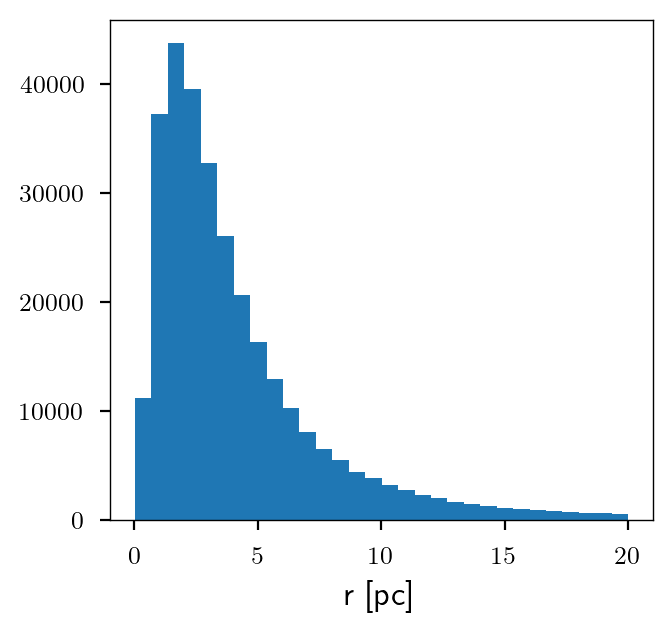

In [228]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(r_samp, bins = 30)
plt.xlabel(r'r [pc]')
plt.show()

In [229]:
v_esc_samp = get_v_esc(M0_samp, a_samp, r_samp)

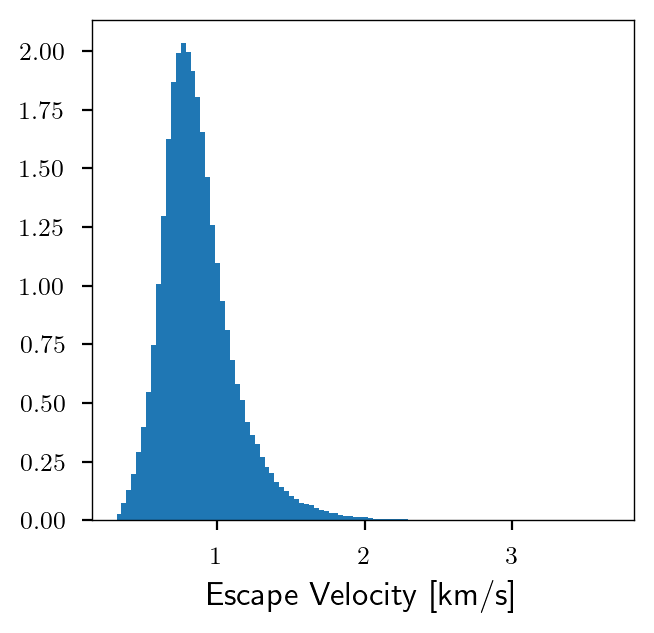

In [230]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(np.log10(v_esc_samp), bins = 100, density = True)
plt.xlabel(r'Escape Velocity [km/s]')
plt.show()

In [231]:
v_init = np.linspace(0, v_esc_samp, 1000).T

In [232]:
pofv_samps = p_of_v(v_init, v_esc_samp[:, np.newaxis])

In [233]:
cdf_samps = integrate.cumulative_trapezoid(pofv_samps, v_init, initial=0, axis = -1)

In [234]:
cdf_samps = cdf_samps / cdf_samps[:, -1][:, None]

In [235]:
v_samp = np.array([np.interp(u[ii], cdf_samps[ii], v_init[ii]) for ii in tqdm(range(N))])

100%|███████████████████████████████████████████████████████████████████████████| 300000/300000 [00:04<00:00, 66554.62it/s]


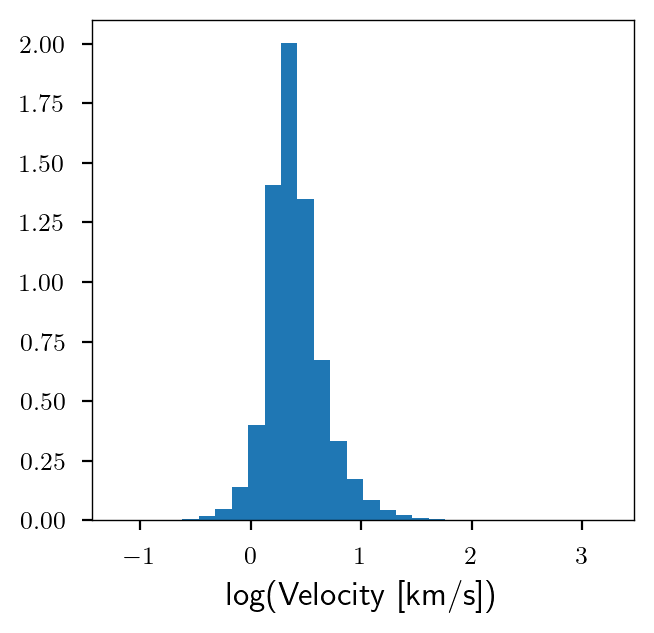

In [236]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(np.log10(v_samp), bins = 30, density = True)
plt.xlabel(r'log(Velocity [km/s])')
plt.show()

In [237]:
v_true_GW241011 = np.sqrt(v_samp**2 + vr_samp_GW241011**2 + 2 * v_samp * vr_samp_GW241011 * cos_theta_samp)

In [238]:
v_true_GW241110 = np.sqrt(v_samp**2 + vr_samp_GW241110**2 + 2 * v_samp * vr_samp_GW241110 * cos_theta_samp)

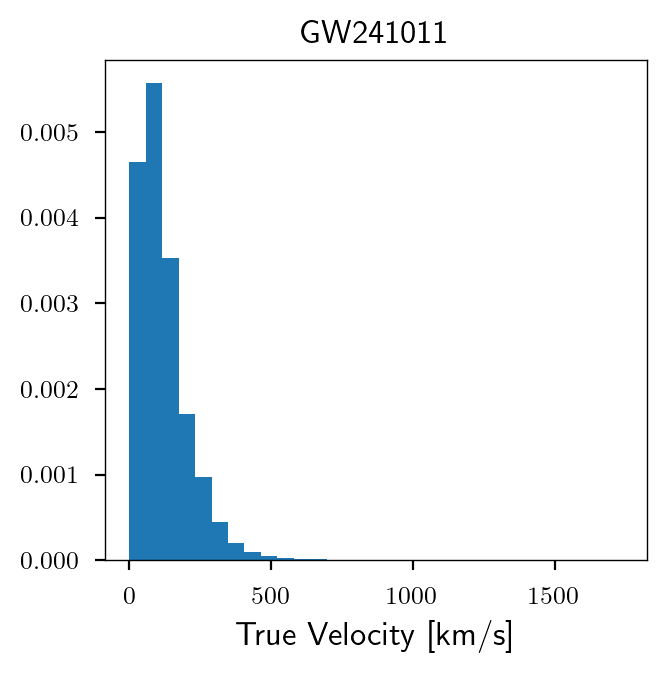

In [239]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(v_true_GW241011, bins = 30, density = True)
plt.xlabel(r'True Velocity [km/s]')
plt.title(r'GW241011')
plt.show()

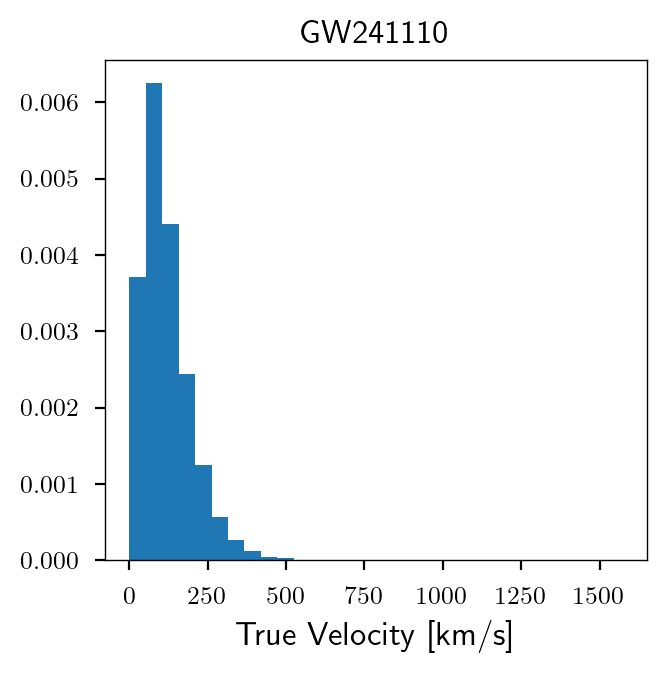

In [240]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(v_true_GW241110, bins = 30, density = True)
plt.xlabel(r'True Velocity [km/s]')
plt.title(r'GW241110')
plt.show()

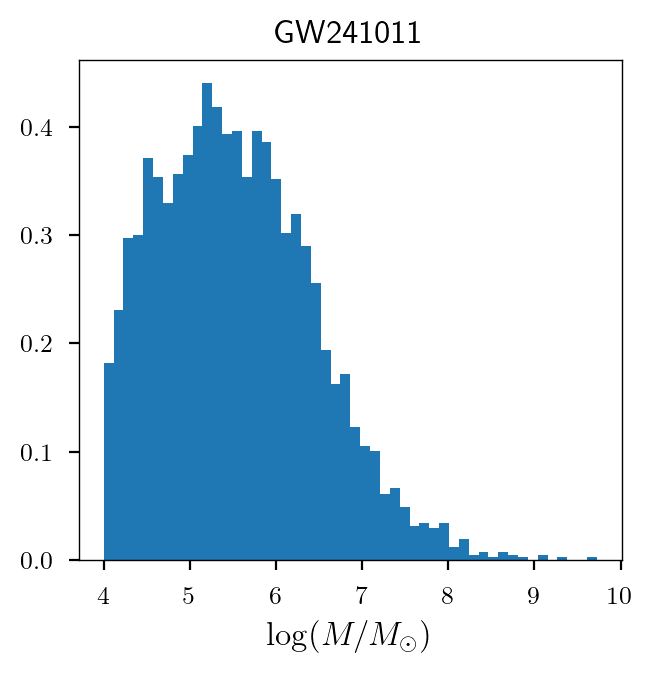

In [241]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(M0_samp[np.where(v_true_GW241011 < v_esc_samp)], bins = 50, density = True)
#plt.hist(10**(M0_samp[idx]), bins = 1000, density = True)
#plt.xscale('log')
plt.xlabel(r'$\log(M / M_{\odot})$')
plt.title(r'GW241011')
plt.show()

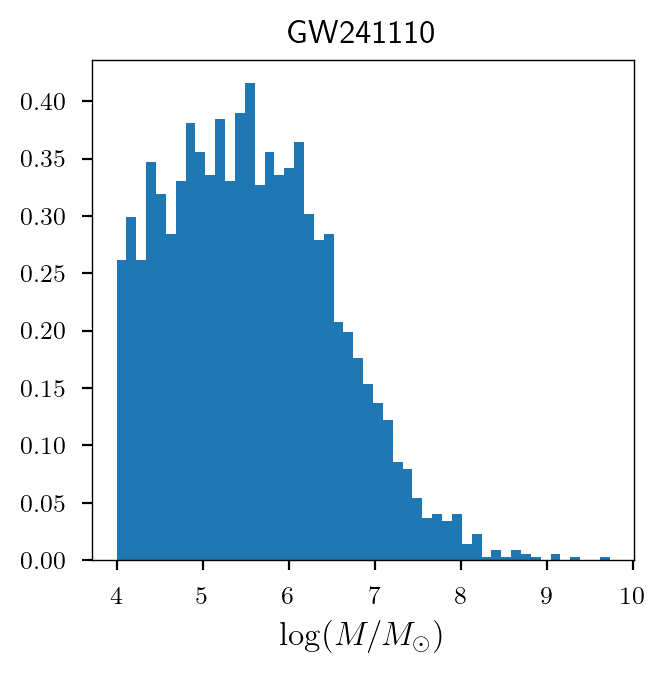

In [242]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(M0_samp[np.where(v_true_GW241110 < v_esc_samp)], bins = 50, density = True)
#plt.hist(10**(M0_samp[idx]), bins = 1000, density = True)
#plt.xscale('log')
plt.xlabel(r'$\log(M / M_{\odot})$')
plt.title(r'GW241110')
plt.show()

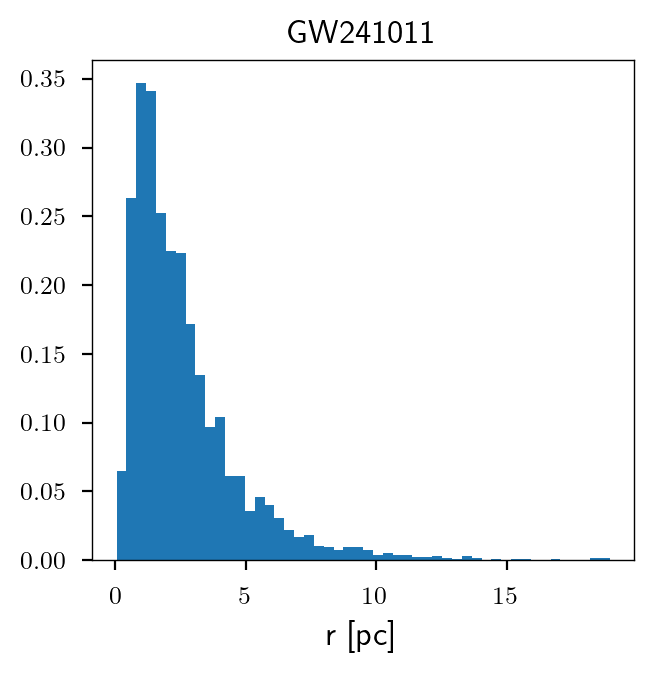

In [243]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(r_samp[np.where(v_true_GW241011 < v_esc_samp)], bins = 50, density = True)
plt.xlabel(r'r [pc]')
plt.title(r'GW241011')
plt.show()

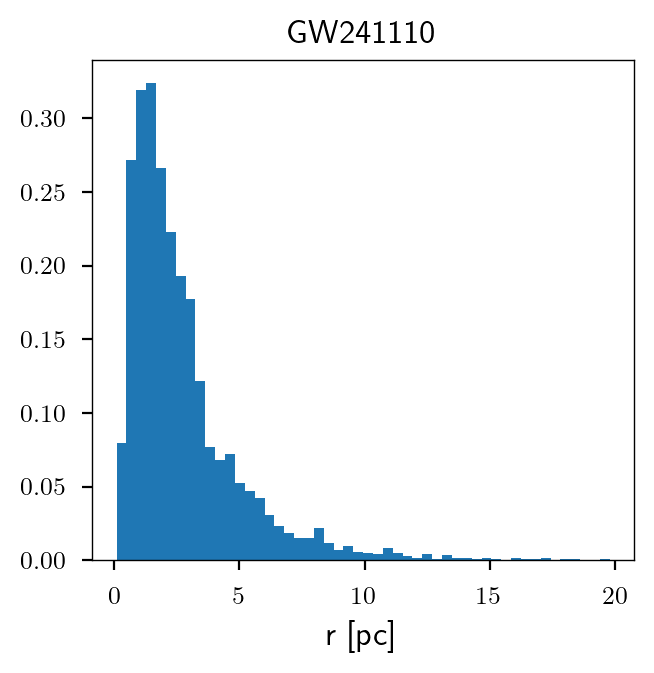

In [244]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(r_samp[np.where(v_true_GW241110 < v_esc_samp)], bins = 50, density = True)
plt.xlabel(r'r [pc]')
plt.title(r'GW241110')
plt.show()